In [1]:
import os
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from transformers import AutoProcessor, CLIPSegForImageSegmentation
from PIL import Image
from subSelectImages import subSelectImages 

def download_clipseg_model():
    print("Loading CLIPSeg model...")
    processor = AutoProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
    model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")
    print("Model loaded successfully.")
    return processor, model

def segmentImages():
    selected_images = subSelectImages()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    processor, model = download_clipseg_model()
    model.to(device)

    mask_filenames = []
    texts = ["a bird"]  

    for image_path in selected_images:
        print(f"Processing {image_path} for segmentation...")

        image = Image.open(image_path).convert("RGB")
        inputs = processor(
            text=texts, 
            images=[image] * len(texts),  
            return_tensors="pt"
        ).to(device)

        with torch.no_grad():
            outputs = model(**inputs)

        logits = outputs.logits  

        mask_array = (logits[0, :, :].cpu().numpy() > -2) * 255  
        mask_image = Image.fromarray(mask_array.astype(np.uint8)).resize(image.size)

        mask_filename = image_path.rsplit(".", 1)[0] + "_mask.png"
        mask_image.save(mask_filename)
        mask_filenames.append(mask_filename)
        print(f"Saved mask: {mask_filename}")

    return mask_filenames

# Example usage
if __name__ == "__main__":
    mask_files = segmentImages()
    print("Generated mask files:", mask_files)

2025-03-06 23:09:53.924049: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741320593.935810    7265 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741320593.939161    7265 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-06 23:09:53.952964: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be t

 Selected Images: ['images/origIm14.jpeg', 'images/origIm2.jpeg', 'images/origIm3.jpeg', 'images/origIm5.jpeg', 'images/origIm6.jpeg']
Using device: cuda
Loading CLIPSeg model...
Model loaded successfully.
Processing images/origIm14.jpeg for segmentation...
Saved mask: images/origIm14_mask.png
Processing images/origIm2.jpeg for segmentation...
Saved mask: images/origIm2_mask.png
Processing images/origIm3.jpeg for segmentation...
Saved mask: images/origIm3_mask.png
Processing images/origIm5.jpeg for segmentation...
Saved mask: images/origIm5_mask.png
Processing images/origIm6.jpeg for segmentation...
Saved mask: images/origIm6_mask.png
Generated mask files: ['images/origIm14_mask.png', 'images/origIm2_mask.png', 'images/origIm3_mask.png', 'images/origIm5_mask.png', 'images/origIm6_mask.png']


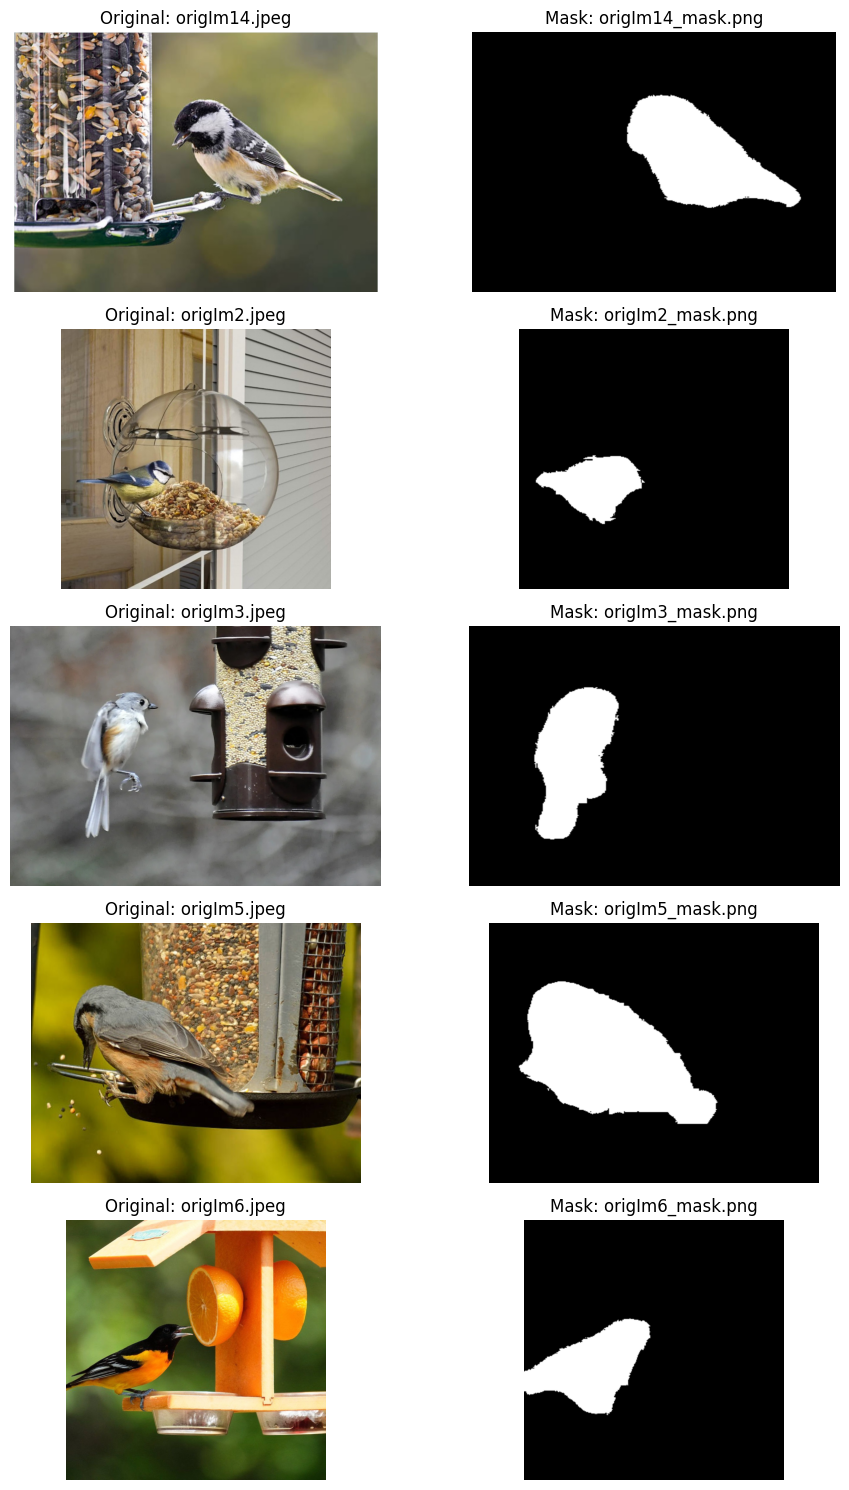

In [2]:
import matplotlib.pyplot as plt
import os
from PIL import Image

# Manually define selected images and their masks (from segmentImages.py output)
selected_images = [
    "images/origIm14.jpeg",
    "images/origIm2.jpeg",
    "images/origIm3.jpeg",
    "images/origIm5.jpeg",
    "images/origIm6.jpeg"
]

mask_files = [
    "images/origIm14_mask.png",
    "images/origIm2_mask.png",
    "images/origIm3_mask.png",
    "images/origIm5_mask.png",
    "images/origIm6_mask.png"
]

# Ensure we have an equal number of images and masks
assert len(selected_images) == len(mask_files), "Mismatch between original images and masks!"

# Set up the figure for visualization
fig, axes = plt.subplots(len(selected_images), 2, figsize=(10, len(selected_images) * 3))

# If only one image, adjust axis indexing
if len(selected_images) == 1:
    axes = [axes]

for i, (img_path, mask_path) in enumerate(zip(selected_images, mask_files)):
    # Load original image
    orig_img = Image.open(img_path)

    # Load corresponding mask
    mask_img = Image.open(mask_path)

    # Display original image
    axes[i, 0].imshow(orig_img)
    axes[i, 0].set_title(f"Original: {os.path.basename(img_path)}")
    axes[i, 0].axis("off")

    # Display segmentation mask
    axes[i, 1].imshow(mask_img, cmap="gray")
    axes[i, 1].set_title(f"Mask: {os.path.basename(mask_path)}")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()
